# Using the PETITE utilities to generate new integrator maps
Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.N. Machado (Fermilab)

! Warning: running this can be time consuming !

* First we will generate all the Standard Model processes ('Brem', 'PairProd', 'Comp', 'Ann', 'Moller', 'Bhabha') for a range of energies.
* Second we will generate integrators for dark Bremsstrahlung for a range of dark vector masses



In [1]:
# import necessary functions
from generate_integrators import *
from find_maxes import *
import numpy as np
import sys, os
path = os.getcwd()
path = os.path.split(path)[0]
print(path)

/Users/kjkelly/Library/CloudStorage/Dropbox/GitHub/PETITE


In [2]:
import PETITE.all_processes as ap
import vegas as vg

In [3]:
class dsigma_moller_dCT_fk:
    def __init__(self, event_info, ndim, batch_mode=False):
        """Moller Scattering of an Electron off an at-rest Electron
        e- (Einc) + e- (me) -> e- + e-

        Input parameters needed:
            Einc (incident electron energy)
        """
        self.event_info = event_info
        self.ndim = ndim
        self.batch_mode = batch_mode

    def __call__(self, phase_space_par_list):

        Ee = self.event_info["E_inc"]
        if "Ee_min" in self.event_info.keys():
            DE = self.event_info["Ee_min"]
        else:
            DE = 0.010

        delta_ct_limit = 2.0 * DE / (Ee - m_electron)

        if self.batch_mode:
            ct = phase_space_par_list[:, 0]
        else:
            ct = phase_space_par_list[0]
        #ct = np.asarray(phase_space_par_list)
        #if self.batch_mode:
        #    ct = ct[:, 0]

        allowed_kinematics = (ct > -1 + delta_ct_limit) & (ct < 1.0 - delta_ct_limit)
        s = m_electron**2 + 2 * Ee * m_electron
        dSigs = np.where(
            allowed_kinematics,
            16
            * np.pi**2
            * alpha_em**2
            * (
                s**2 * (3 + ct**2) ** 2
                - 8 * m_electron**2 * s * (7 + ct**4)
                + 16 * m_electron**4 * (6 - 3 * ct**2 + ct**4)
            )
            / (
                8
                * np.pi
                * s
                * (s - 4 * m_electron**2) ** 2
                * (1 - ct) ** 2
                * (1 + ct) ** 2
            ),
            0,
        )

        return dSigs

In [11]:
np.__version__

'2.1.3'

In [18]:
process = "Moller"
int_option = ap.vegas_integrator_options[process]
#diff_xsec = dsigma_moller_dCT_fk
diff_xsec = ap.diff_xsection_options[process]
Ei = 2.0
params = {"E_inc":Ei, "m_lepton":m_electron, "mV":0.0}

if not ("mV" in params.keys()):
    params["mV"] = 0.0
if not ("Eg_min" in params.keys()):
    params["Eg_min"] = 0.001
if not ("Ee_min" in params.keys()):
    params["Ee_min"] = 0.005
if not ("m_lepton" in params.keys()):
    params["m_lepton"] = m_electron

ig_r = ap.integration_range(params, process)
print(ig_r)

integ = vg.Integrator(ig_r)
f_integrand = diff_xsec(event_info=params, ndim=1, batch_mode=True)

[[-0.9949987221761417, 0.9949987221761417]]


In [20]:
f_integrand([[0.5, 0.3]])

TypeError: list indices must be integers or slices, not tuple

In [21]:
integ(f_integrand, **int_option)

261.6068(37)

In [14]:
#initial_energy_list = np.geomspace(0.002, 1000, 501)
initial_energy_list = np.array([0.050])
xsec_elec = []
for Ei in initial_energy_list:
    params = {"E_inc":Ei, "m_lepton":m_electron}
    params['Z_T'] = target_information["graphite"]["Z_T"]
    params['A_T'] = target_information["graphite"]["A_T"]
    v0 = vegas_integration(params, "Moller", verbose=True, mode="XSec")
    xsec_elec.append(v0)
xsec_elec = np.array(xsec_elec)

Integrator set up Moller {'E_inc': np.float64(0.05), 'm_lepton': 0.0005109989499999999, 'Z_T': 6, 'A_T': 12, 'mV': 0.0, 'Eg_min': 0.001, 'Ee_min': 0.005}


ValueError: cannot reshape array of size 1 into shape (8000,newaxis)

In [77]:
mu_xsec = np.load("muon_xsec_graphite.npy")
mue_xsec = np.load("muon_electron_xsec.npy")
mue_xsec2 = np.load("muon_electron_xsec_v2.npy")
mu_e = np.geomspace(0.200, 1000, 501)
e_e = np.geomspace(0.002, 1000, 501)
e_e2 = np.geomspace(0.002, 100000, 501)
e_xsec = np.load("electron_xsec_graphite.npy")
ee_xsec = np.load("electron_electron_xsec.npy")
ee_xsec2 = np.load("electron_electron_xsec_v2.npy")

In [78]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$E_{\\ell}\\ \\mathrm{[GeV]}$')

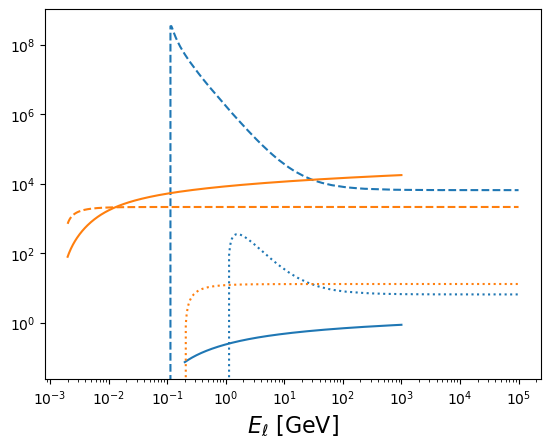

In [79]:
plt.plot(mu_e, mu_xsec, label="Muon")
plt.plot(e_e2, mue_xsec, label="Muon", color='C0', ls='--')
plt.plot(e_e2, mue_xsec2, label="Muon", color='C0', ls=':')
plt.plot(e_e, e_xsec, label="Electron", color='C1')
plt.plot(e_e2, ee_xsec, label="Electron", color='C1', ls='--')
plt.plot(e_e2, ee_xsec2, label="Electron", color='C1', ls=':')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.gca().set_xlabel(r"$E_{\ell}\ \mathrm{[GeV]}$", fontsize=16)


In [3]:
##################################
##         SM processes         ##
##################################
# List of incoming particle energies at which to calculate integrators for each process
initial_energy_list = np.logspace(np.log10(0.0016), np.log10(100), 100)
# Necessary parameters for generating the integrators, note save_location should be altered as preferred
training_params = {'verbosity':True, 'initial_energy_list':initial_energy_list,
                   'save_location':path + '/coarsegrid_test',
                   'run_find_maxes':True}
# Necessary parameters for processing the integrators to determine cross sections
processing_params = {'process_targets':['graphite','lead'], 'save_location':path + '/coarsegrid_test'}
#args = training_params.update(processing_params)
# List of processes to do
processes_to_do = ['Brem', 'PairProd', 'Comp', 'Ann', 'Moller', 'Bhabha']
# Loop over processes, carrying out each step of the calculation, they can also be called in one command generate_integrators
for process in processes_to_do:
    make_integrators(training_params, process)
    stitch_integrators(training_params['save_location'] + '/' + process + '/')
    cleanup(training_params['save_location'] + "/" + process + "/")
# List of processes to run find_maxes on, need not be the same as list above
find_maxes_processes_to_do = ['Brem', 'PairProd', 'Comp', 'Ann', 'Moller', 'Bhabha']
call_find_maxes(processing_params, find_maxes_processes_to_do)


Parameters:
{'verbosity': True, 'initial_energy_list': array([1.60000000e-03, 1.78880589e-03, 1.99989156e-03, 2.23588612e-03,
       2.49972891e-03, 2.79470611e-03, 3.12449172e-03, 3.49319323e-03,
       3.90540288e-03, 4.36625479e-03, 4.88148892e-03, 5.45752257e-03,
       6.10153030e-03, 6.82153333e-03, 7.62649935e-03, 8.52645433e-03,
       9.53260730e-03, 1.06574900e-02, 1.19151131e-02, 1.33211402e-02,
       1.48930838e-02, 1.66505225e-02, 1.86153454e-02, 2.08120246e-02,
       2.32679200e-02, 2.60136202e-02, 2.90833231e-02, 3.25152622e-02,
       3.63521827e-02, 4.06418740e-02, 4.54377646e-02, 5.07995880e-02,
       5.67941263e-02, 6.34960421e-02, 7.09888086e-02, 7.93657492e-02,
       8.87311995e-02, 9.92018075e-02, 1.10907986e-01, 1.23995536e-01,
       1.38627465e-01, 1.54986016e-01, 1.73274936e-01, 1.93722016e-01,
       2.16581927e-01, 2.42139391e-01, 2.70712729e-01, 3.02657827e-01,
       3.38372564e-01, 3.78301772e-01, 4.22942772e-01, 4.72851575e-01,
       5.28649800e-01,

In [2]:
##################################
##         Dark processes       ##
##################################
initial_energy_list = np.logspace(np.log10(0.01), np.log10(100), 100)
# Dark vector masses in GeV
#mV_list = [0.001, 0.003, 0.010, 0.030, 0.100, 0.300, 1.00]
mV_list = [0.003, 0.030, 0.300]
save_location = path + '/coarsegrid_test/'
training_params = {'verbosity':True, 'initial_energy_list':initial_energy_list,
                   'save_location':save_location,
                   'run_find_maxes':True, 'mV_list':mV_list, 'training_target':'hydrogen', 'mT':200.0}
#processes_to_do = ['DarkBrem', 'DarkAnn']
processes_to_do = ['DarkComp']

for mV in mV_list:
    for process in processes_to_do:
        if process == 'DarkBrem':
            if mV > initial_energy_list[0]:
                initial_energy_list = np.logspace(np.log10(1.01*mV), np.log10(initial_energy_list[-1]), len(initial_energy_list))
                training_params.update({'initial_energy_list':initial_energy_list})
        if process == 'DarkAnn':
            if mV**2 > 2*m_electron*(initial_energy_list[0] + m_electron):
                Ee0 = 1.01*((mV**2 - 2*m_electron**2)/(2*m_electron))
                initial_energy_list = np.logspace(np.log10(Ee0), np.log10(initial_energy_list[-1]), len(initial_energy_list))
                training_params.update({'initial_energy_list':initial_energy_list})
        training_params.update({"mV":mV})
        make_integrators(training_params, process)
        stitch_integrators(training_params['save_location'] + process + '/mV_' + str(int(np.floor(mV*1000.))) + "MeV/")
        cleanup(training_params['save_location'] + process + '/mV_' + str(int(np.floor(mV*1000.))) + "MeV/")

processes_to_do = ['DarkBrem', 'DarkAnn', 'DarkComp']
processing_params = {'process_targets':['graphite','lead'], 'save_location':save_location, 'mV_list':mV_list}
call_find_maxes(processing_params, processes_to_do)

Using specified m_T = 200.0
Parameters:
{'verbosity': True, 'initial_energy_list': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5.33669923e-02, 5.85702082e-02,
       6.42807312e-02, 7.05480231e-02, 7.74263683e-02, 8.49753436e-02,
       9.32603347e-02, 1.02353102e-01, 1.12332403e-01, 1.23284674e-01,
       1.35304777e-01, 1.48496826e-01, 1.62975083e-01, 1.78864953e-01,
       1.96304065e-01, 2.15443469e-01, 2.36448941e-01, 2.59502421e-01,
       2.84803587e-01, 3.12571585e-01, 3.43046929e-01, 3.76493581e-01,
       4.13201240e-01, 4.53487851e-01, 4.97702356e-01, 5.46227722e-01,
       5.99484250e-01, 6.57933225e-01, 7.22080902e-01, 7.92482898e-01,
       8.69749003e-01, 9.54548457e-01, 1.04761575e+00, 1.14975700